In [118]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset,DataLoader
from sklearn.datasets import load_iris,load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


wine = load_wine()


wine.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names'])

In [119]:
X = wine.data

y = wine.target


In [120]:
X_train,X_test,y_train,y_test = train_test_split(X,y)



In [121]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [122]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_train_tensor = torch.tensor(X_train_scaled,dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test_scaled,dtype=torch.float32).to(device)

y_train_tensor = torch.tensor(y_train,dtype=torch.long).to(device)
y_test_tensor = torch.tensor(y_test,dtype=torch.int).to(device)



In [123]:

train_dataset = TensorDataset(X_train_tensor,y_train_tensor)
train_loader = DataLoader(train_dataset,batch_size=32,shuffle=True)

In [124]:
class mlt_clf(nn.Module):

    def __init__(self,input_dim,output_dim):
            super().__init__()
            self.linear1 = nn.Linear(input_dim,32)
            self.linear2 = nn.Linear(32,10)
            self.output = nn.Linear(10,output_dim)
            self.relu = nn.ReLU()
            self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self,x):
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.output(x)

        return x


In [125]:
input_dim = X_train_tensor.shape[1]
output_dim = len(torch.unique(y_train_tensor))
model = mlt_clf(input_dim=input_dim,output_dim=output_dim).to(device)

In [126]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.01)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,mode='max',factor=0.5,patience=3,verbose= True   
)

c:\Users\main\miniforge3\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [127]:
nb_epoch = 50
best_acc = 0
cnt = 0
patience = 5

for epoch in range(nb_epoch+1):
    # 학습 할거다 선언
    model.train()

    for batch_x,batch_y in train_loader:
        pred = model(batch_x)

        loss = criterion(pred,batch_y)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

    model.eval()

    with torch.no_grad():
        test_pred = model(X_test_tensor)
        pred_trgt = torch.argmax(test_pred,axis=1)
        acc = (pred_trgt == y_test_tensor).float().mean().item()

        scheduler.step(acc)
        print(f'{epoch} / {nb_epoch} | Test acc : {acc * 100:.2f}%')

        # 조기종료

        if acc > best_acc :
            best_acc = acc
            cnt = 0
            torch.save(model.state_dict(),"best_wine_model.pt")
        else :
            cnt += 1
        if cnt >= patience:
            print('조기종료')    
            break;
print(f'최종 정확도 : {best_acc}')

0 / 50 | Test acc : 55.56%
1 / 50 | Test acc : 55.56%
2 / 50 | Test acc : 77.78%
3 / 50 | Test acc : 93.33%
4 / 50 | Test acc : 93.33%
5 / 50 | Test acc : 93.33%
6 / 50 | Test acc : 95.56%
7 / 50 | Test acc : 95.56%
8 / 50 | Test acc : 95.56%
9 / 50 | Test acc : 95.56%
10 / 50 | Test acc : 95.56%
11 / 50 | Test acc : 95.56%
조기종료
최종 정확도 : 0.9555555582046509


In [130]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
# 손실 함수와 gradient 정의
def loss(w):
    return w[0]**2 + w[1]**2

def gradient(w):
    return np.array([2*w[0], 2*w[1]])

# 초기 위치와 설정
w = np.array([2.5, 2.5])
lr = 0.1  # 학습률
history = [w.copy()]

# 경사하강법 30회 반복
for _ in range(30):
    grad = gradient(w)
    w = w - lr * grad
    history.append(w.copy())

history = np.array(history)

# 손실 함수 등고선
w1 = np.linspace(-3, 3, 100)
w2 = np.linspace(-3, 3, 100)
W1, W2 = np.meshgrid(w1, w2)
Loss = W1**2 + W2**2

# 애니메이션 그리기
fig, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(W1, W2, Loss, levels=50, cmap='viridis')
plt.colorbar(contour, ax=ax, label='Loss')
ax.set_title("Gradient Descent Animation")
ax.set_xlabel("W1")
ax.set_ylabel("W2")

point, = ax.plot([], [], 'ro')         # 현재 위치
path, = ax.plot([], [], 'w--', alpha=0.7)  # 이동 경로

def init():
    point.set_data([], [])
    path.set_data([], [])
    return point, path

def update(frame):
    point.set_data(history[frame][0], history[frame][1])
    path.set_data(history[:frame+1, 0], history[:frame+1, 1])
    return point, path

ani = animation.FuncAnimation(fig, update, frames=len(history), init_func=init,
                              interval=200, blit=True)

plt.close()  # 애니메이션만 보여주기
ani


C:\Users\main\AppData\Local\Temp\ipykernel_14020\1515570582.py:39: UserWarning: Glyph 54596 (\N{HANGUL SYLLABLE PIL}) missing from font(s) DejaVu Sans.
  ani = animation.FuncAnimation(fig, update, frames=len(positions), interval=500, blit=True)
C:\Users\main\AppData\Local\Temp\ipykernel_14020\1515570582.py:39: UserWarning: Glyph 53552 (\N{HANGUL SYLLABLE TEO}) missing from font(s) DejaVu Sans.
  ani = animation.FuncAnimation(fig, update, frames=len(positions), interval=500, blit=True)
C:\Users\main\AppData\Local\Temp\ipykernel_14020\1515570582.py:39: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
  ani = animation.FuncAnimation(fig, update, frames=len(positions), interval=500, blit=True)
C:\Users\main\AppData\Local\Temp\ipykernel_14020\1515570582.py:39: UserWarning: Glyph 51077 (\N{HANGUL SYLLABLE IB}) missing from font(s) DejaVu Sans.
  ani = animation.FuncAnimation(fig, update, frames=len(positions), interval=500, blit=True)
C:\Users\main\AppData\

FileNotFoundError: [WinError 3] 지정된 경로를 찾을 수 없습니다: '\\mnt\\data'

c:\Users\main\miniforge3\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 54596 (\N{HANGUL SYLLABLE PIL}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
c:\Users\main\miniforge3\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 53552 (\N{HANGUL SYLLABLE TEO}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
c:\Users\main\miniforge3\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
c:\Users\main\miniforge3\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 51077 (\N{HANGUL SYLLABLE IB}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
c:\Users\main\miniforge3\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 47141 (\N{HANGUL SYLLABLE RYEOG}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
c:\Users\main\miniforge3\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 51012 (\N{HANGUL

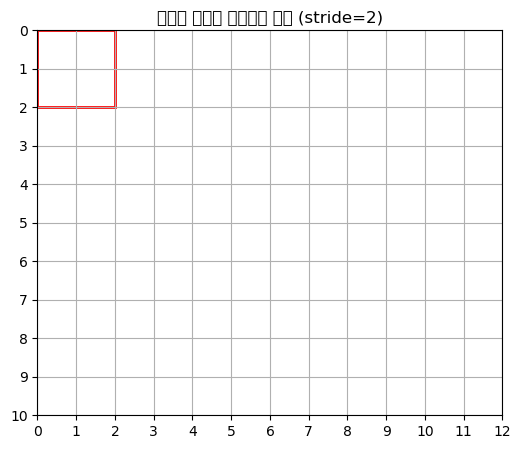

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation
import numpy as np

# 입력 데이터 크기 (패딩 포함)
input_h, input_w = 10, 12
filter_size = 2
stride = 2

# 전체 이미지 (배경용)
input_img = np.ones((input_h, input_w))

# 애니메이션 그림 설정
fig, ax = plt.subplots(figsize=(6, 5))
ax.set_xlim(0, input_w)
ax.set_ylim(0, input_h)
ax.set_xticks(np.arange(0, input_w + 1, 1))
ax.set_yticks(np.arange(0, input_h + 1, 1))
ax.grid(True)
ax.invert_yaxis()
rect = patches.Rectangle((0, 0), filter_size, filter_size, linewidth=2, edgecolor='red', facecolor='none')
ax.add_patch(rect)
ax.set_title("필터가 입력을 스캔하는 과정 (stride=2)")

# 필터가 이동할 위치 계산
positions = []
for i in range(0, input_h - filter_size + 1, stride):
    for j in range(0, input_w - filter_size + 1, stride):
        positions.append((j, i))  # (x, y)

# 애니메이션 업데이트 함수
def update(frame):
    x, y = positions[frame]
    rect.set_xy((x, y))
    return rect,

# 애니메이션 생성
ani = animation.FuncAnimation(fig, update, frames=len(positions), interval=500, blit=True)

# mp4로 저장 후 출력
video_path = "data/filter_stride2_animation.mp4"
ani.save(video_path, writer='ffmpeg', fps=2)
plt.close()

from IPython.display import Video
Video(video_path, embed=True)
